In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
import os
import sys


root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(root_dir)

from utils.utils import *
from utils.constant import *

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")
# Set a seed for reproducibility
np.random.seed(42)


In [2]:
file_path = get_absolute_path(
    'one_day.csv',
    'data',
    PROJECT_BASE_DIR
)

data = pd.read_csv(file_path)

In [3]:
data.head(3)

,ORDER_PLACED_DTTM,PRODUCT_PART_NUMBER,TOTAL_UNITS,TOTAL_CURRENT_ON_HAND,CATEGORY_LEVEL1,CATEGORY_LEVEL2,CATEGORY_LEVEL3,MERCH_CLASSIFICATION1,MERCH_CLASSIFICATION2,MERCH_CLASSIFICATION3,LIST_PRICE,RATING_AVG,RATING_CNT
0,2023-09-04,100004,63.0,3470,Dog,Treats,Biscuits & Crunchy Treats,Consumables,Core Treats,Indulgent Treats,3.29,4.5855,345.0
1,2023-09-04,100006,69.0,4341,Dog,Treats,Biscuits & Crunchy Treats,Consumables,Core Treats,Indulgent Treats,3.29,4.6319,546.0
2,2023-09-04,100012,227.0,6933,Dog,Treats,Jerky Treats,Consumables,Core Treats,Indulgent Treats,12.99,4.4059,409.0


In [4]:
### Basic Information about the Datasets

# Display basic information about the dataset
print(data.info())

# Display summary statistics for numerical columns
print(data.describe())

# Check for missing values
print(data.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36559 entries, 0 to 36558
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ORDER_PLACED_DTTM      36559 non-null  object 
 1   PRODUCT_PART_NUMBER    36559 non-null  int64  
 2   TOTAL_UNITS            36559 non-null  float64
 3   TOTAL_CURRENT_ON_HAND  36559 non-null  int64  
 4   CATEGORY_LEVEL1        36559 non-null  object 
 5   CATEGORY_LEVEL2        36559 non-null  object 
 6   CATEGORY_LEVEL3        36559 non-null  object 
 7   MERCH_CLASSIFICATION1  36555 non-null  object 
 8   MERCH_CLASSIFICATION2  36555 non-null  object 
 9   MERCH_CLASSIFICATION3  36555 non-null  object 
 10  LIST_PRICE             32329 non-null  float64
 11  RATING_AVG             34533 non-null  float64
 12  RATING_CNT             34533 non-null  float64
dtypes: float64(4), int64(2), object(7)
memory usage: 3.6+ MB
None
       PRODUCT_PART_NUMBER    TOTAL_UNITS  T

In [5]:
data.columns

Index(['ORDER_PLACED_DTTM', 'PRODUCT_PART_NUMBER', 'TOTAL_UNITS',
       'TOTAL_CURRENT_ON_HAND', 'CATEGORY_LEVEL1', 'CATEGORY_LEVEL2',
       'CATEGORY_LEVEL3', 'MERCH_CLASSIFICATION1', 'MERCH_CLASSIFICATION2',
       'MERCH_CLASSIFICATION3', 'LIST_PRICE', 'RATING_AVG', 'RATING_CNT'],
      dtype='object')

In [6]:
# All product_part_numbers of MC3 == 'Dry Food'
id_list = data.loc[data['MERCH_CLASSIFICATION3'] == 'Dry Food', 'PRODUCT_PART_NUMBER'].unique()

# Specify the number of IDs we want to randomly select
num_ids_to_select = 5

# Randomly select IDs
randomly_selected_ids = np.random.choice(id_list, size=num_ids_to_select, replace=False)

print(randomly_selected_ids)

[182033 114495  77463 239943  49534]


## 1. Time Series Analysis

- Visualize the time series of 'NET_SALES' and 'UNITS' over the given period
- Check for seasonality, trends, and unusual patterns

In [7]:
# Convert 'ORDER_PLACED_DTTM' to datetime
data['ORDER_PLACED_DTTM'] = pd.to_datetime(data['ORDER_PLACED_DTTM'])

# Set 'ORDER_PLACED_DTTM' as the index for time series analysis
data.set_index('ORDER_PLACED_DTTM', inplace=True)

#### Segment the Data Based on PRODUCT_CATEGORY_LEVEL3 and PRODUCT_CATEGORY_LEVEL1

In [8]:
segment_group_data = data.groupby(['ORDER_PLACED_DTTM', 'CATEGORY_LEVEL1', 'MERCH_CLASSIFICATION3'])[[
   'TOTAL_UNITS',
 'LIST_PRICE',
 'RATING_AVG',
 'RATING_CNT',
 'TOTAL_CURRENT_ON_HAND'
]].sum().reset_index()

# Convert 'ORDER_PLACED_DTTM' to datetime
segment_group_data['ORDER_PLACED_DTTM'] = pd.to_datetime(segment_group_data['ORDER_PLACED_DTTM'])

# Set 'ORDER_PLACED_DTTM' as the index for time series analysis
segment_group_data.set_index('ORDER_PLACED_DTTM', inplace=True)

# Combine 'PRODUCT_CATEGORY_LEVEL1' and 'PRODUCT_CATEGORY_LEVEL3' into a new column
segment_group_data['SEGMENT'] = segment_group_data['CATEGORY_LEVEL1'] + ' - ' + segment_group_data['MERCH_CLASSIFICATION3']

# Convert the index to datetime
segment_group_data.index = pd.to_datetime(segment_group_data.index)

# Only keep columns I need
segment_group_data = segment_group_data[['SEGMENT', 
                                        'TOTAL_UNITS',
 'LIST_PRICE',
 'RATING_AVG',
 'RATING_CNT',
 'TOTAL_CURRENT_ON_HAND'
                                        ]]


In [9]:

segment_group_data

,SEGMENT,TOTAL_UNITS,LIST_PRICE,RATING_AVG,RATING_CNT,TOTAL_CURRENT_ON_HAND
ORDER_PLACED_DTTM,,,,,,
2023-09-04,Bird - Food,4030.0,10430.67,1306.3756,14268.0,200209
2023-09-04,Bird - Grooming & Waste Management,182.0,595.09,74.1151,720.0,6765
2023-09-04,Bird - Habitat,57.0,4441.60,148.1795,1320.0,3614
2023-09-04,Bird - Habitat Accessories,99.0,625.24,119.3506,2979.0,6688
2023-09-04,Bird - Health & Wellness,186.0,1223.62,190.8515,410.0,15368
...,...,...,...,...,...,...
2023-09-04,Wild Bird - Food,7884.0,5868.17,1030.4695,16262.0,535778
2023-09-04,Wild Bird - Grooming & Waste Management,8.0,48.89,18.6220,65.0,909
2023-09-04,Wild Bird - Habitat,27.0,653.90,44.8468,121.0,3139


In [10]:
# Group by columns and calculate the size (counts)
segment_counts = segment_group_data.groupby(['SEGMENT']).size().reset_index(name='COUNTS')

# Sort the counts in descending order
sorted_segment_counts = segment_counts.sort_values(by='COUNTS', ascending=False)

# Display the sorted counts
print(sorted_segment_counts)


                                   SEGMENT  COUNTS
0                              Bird - Food       1
182                 Dog - Skin & Coat Care       1
168        Dog - Personalized Pet Products       1
169              Dog - Pill Administration       1
170                       Dog - Plush Toys       1
..                                     ...     ...
94     Chicken - Apparel & People Products       1
95                          Chicken - Food       1
96   Chicken - Grooming & Waste Management       1
97                       Chicken - Habitat       1
265                     Wild Bird - Treats       1

[266 rows x 2 columns]


In [11]:
# save data
saved_segment_group_data = segment_group_data
saved_segment_group_data_file_path = get_absolute_path(
    'segment_group_data.csv',
    'data/_small_set_sales_by_date_sku_zip',
    PROJECT_BASE_DIR
)

saved_segment_group_data.to_csv(saved_segment_group_data_file_path)

In [12]:
saved_segment_group_data

,SEGMENT,TOTAL_UNITS,LIST_PRICE,RATING_AVG,RATING_CNT,TOTAL_CURRENT_ON_HAND
ORDER_PLACED_DTTM,,,,,,
2023-09-04,Bird - Food,4030.0,10430.67,1306.3756,14268.0,200209
2023-09-04,Bird - Grooming & Waste Management,182.0,595.09,74.1151,720.0,6765
2023-09-04,Bird - Habitat,57.0,4441.60,148.1795,1320.0,3614
2023-09-04,Bird - Habitat Accessories,99.0,625.24,119.3506,2979.0,6688
2023-09-04,Bird - Health & Wellness,186.0,1223.62,190.8515,410.0,15368
...,...,...,...,...,...,...
2023-09-04,Wild Bird - Food,7884.0,5868.17,1030.4695,16262.0,535778
2023-09-04,Wild Bird - Grooming & Waste Management,8.0,48.89,18.6220,65.0,909
2023-09-04,Wild Bird - Habitat,27.0,653.90,44.8468,121.0,3139


In [14]:
# List of segments to include in the visualization
selected_segments = ['Dog - Natural',
                    #  'Dog - Freeze-Dried & Dehydrated Food Toppings',
                    #  'Dog - Eye & Ear Grooming',
                     'Cat - Wet Food',
                    # 'Pharmacy - Parasiticide'
                    ]


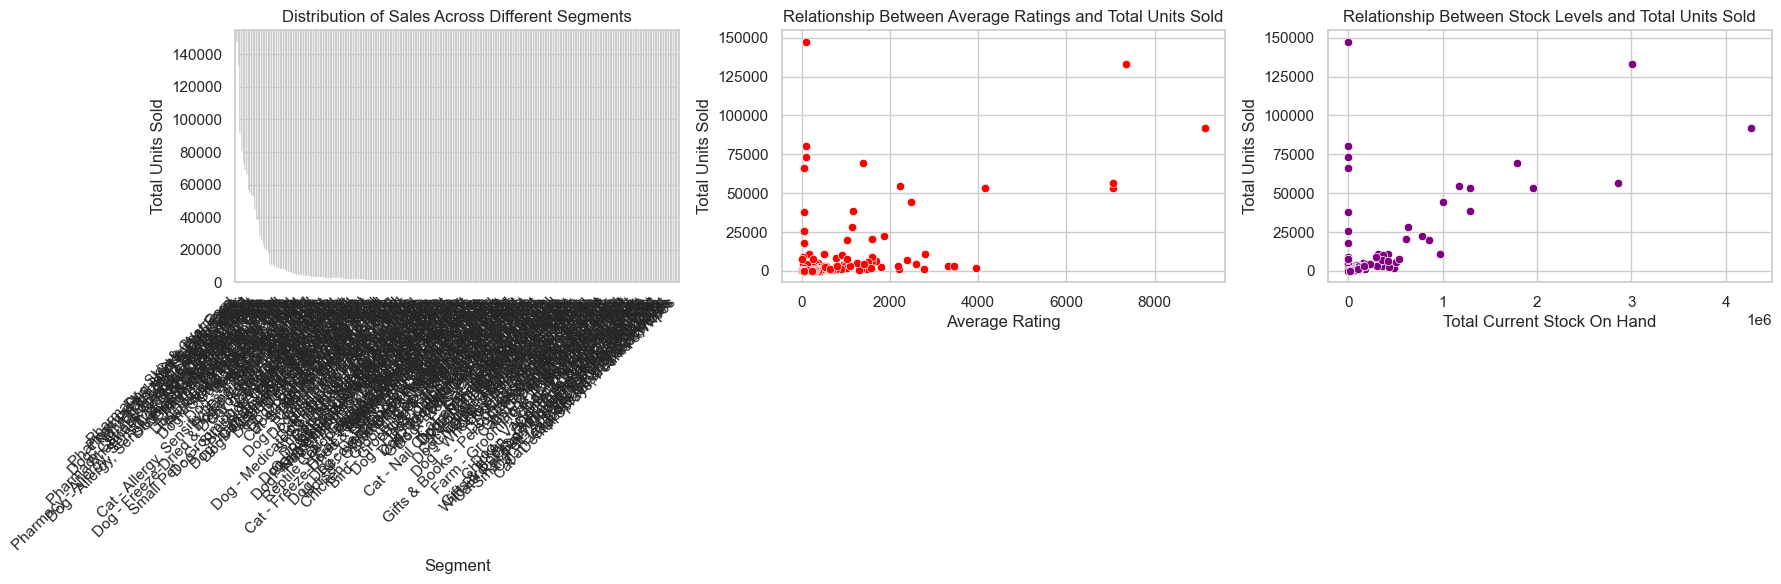

In [18]:
# Setting up the plotting area
plt.figure(figsize=(18, 6))

# Bar Chart: Distribution of Sales Across Different Segments for the given day
plt.subplot(1, 3, 1)
segment_sales = saved_segment_group_data.groupby('SEGMENT')['TOTAL_UNITS'].sum().sort_values(ascending=False)
segment_sales.plot(kind='bar', color='green')
plt.title('Distribution of Sales Across Different Segments')
plt.xlabel('Segment')
plt.ylabel('Total Units Sold')
plt.xticks(rotation=45, ha='right')

# Scatter Plot: Relationship Between Average Ratings and Total Units Sold
plt.subplot(1, 3, 2)
sns.scatterplot(data=saved_segment_group_data, x='RATING_AVG', y='TOTAL_UNITS', color='red')
plt.title('Relationship Between Average Ratings and Total Units Sold')
plt.xlabel('Average Rating')
plt.ylabel('Total Units Sold')

# Plot: Relationship Between Stock Levels and Total Units Sold
plt.subplot(1,3,3)
sns.scatterplot(data=saved_segment_group_data, x='TOTAL_CURRENT_ON_HAND', y='TOTAL_UNITS', color='purple')
plt.title('Relationship Between Stock Levels and Total Units Sold')
plt.xlabel('Total Current Stock On Hand')
plt.ylabel('Total Units Sold')

plt.tight_layout()
plt.show()

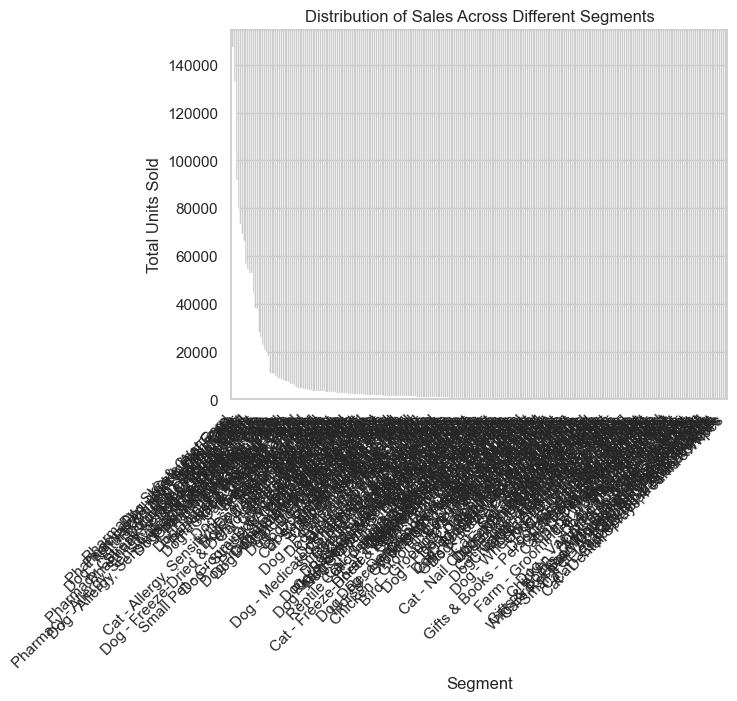

In [19]:
# Bar Chart: Distribution of Sales Across Different Segments for the given day

segment_sales = saved_segment_group_data.groupby('SEGMENT')['TOTAL_UNITS'].sum().sort_values(ascending=False)
segment_sales.plot(kind='bar', color='green')
plt.title('Distribution of Sales Across Different Segments')
plt.xlabel('Segment')
plt.ylabel('Total Units Sold')
plt.xticks(rotation=45, ha='right')
plt.show()

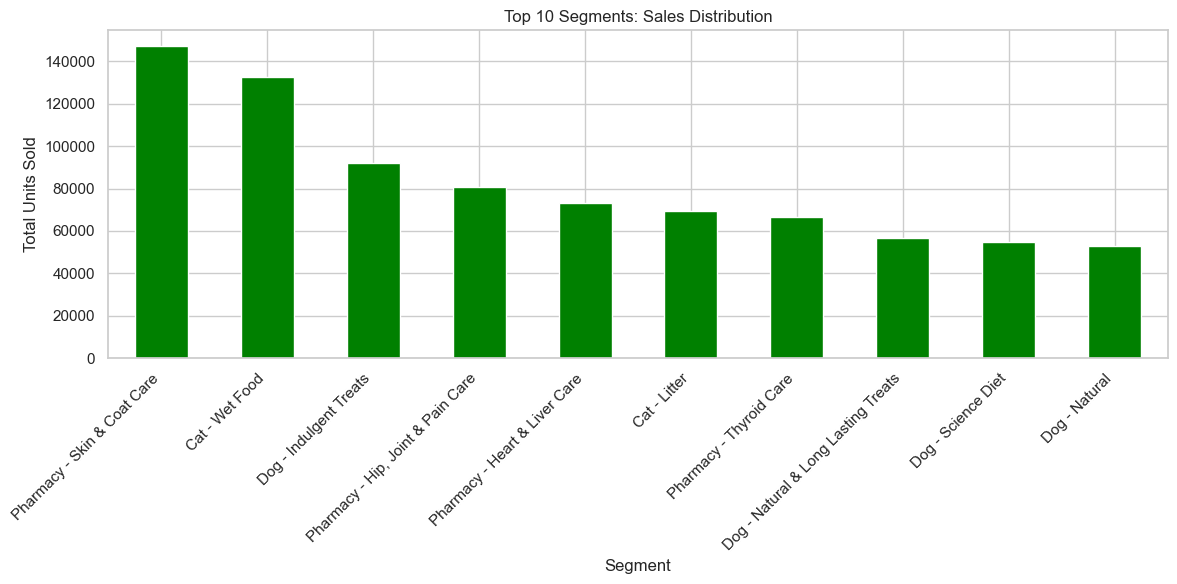

In [20]:
# Since the DataFrame name is 'saved_segment_group_data', let's use that for the visualizations

# Improved visualizations with a simpler design

# Setting up the plotting area with a more focused layout
plt.figure(figsize=(12, 6))

# Bar Chart: Distribution of Sales Across Different Segments for the given day
# Simplifying the chart by showing only the top 10 segments for clarity
top_segments = saved_segment_group_data.groupby('SEGMENT')['TOTAL_UNITS'].sum().sort_values(ascending=False).head(10)
top_segments.plot(kind='bar', color='green')
plt.title('Top 10 Segments: Sales Distribution')
plt.xlabel('Segment')
plt.ylabel('Total Units Sold')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


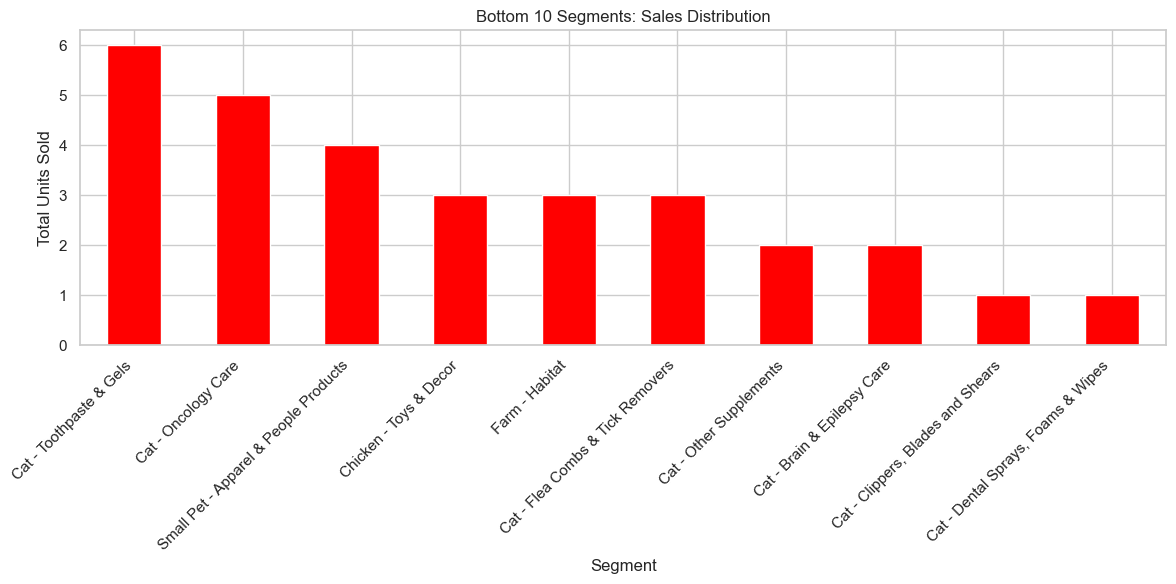

In [22]:
# Since the DataFrame name is 'saved_segment_group_data', let's use that for the visualizations

# Improved visualizations with a simpler design

# Setting up the plotting area with a more focused layout
plt.figure(figsize=(12, 6))

# Bar Chart: Distribution of Sales Across Different Segments for the given day
# Simplifying the chart by showing only the top 10 segments for clarity
top_segments = saved_segment_group_data.groupby('SEGMENT')['TOTAL_UNITS'].sum().sort_values(ascending=False).tail(10)
top_segments.plot(kind='bar', color='red')
plt.title('Bottom 10 Segments: Sales Distribution')
plt.xlabel('Segment')
plt.ylabel('Total Units Sold')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


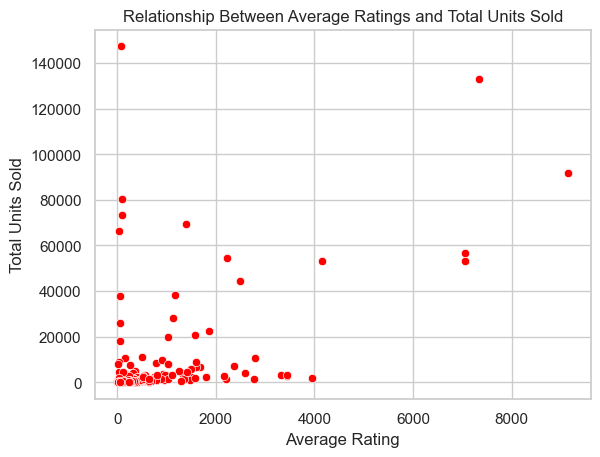

In [23]:
# Scatter Plot: Relationship Between Average Ratings and Total Units Sold

sns.scatterplot(data=saved_segment_group_data, x='RATING_AVG', y='TOTAL_UNITS', color='red')
plt.title('Relationship Between Average Ratings and Total Units Sold')
plt.xlabel('Average Rating')
plt.ylabel('Total Units Sold')
plt.show()

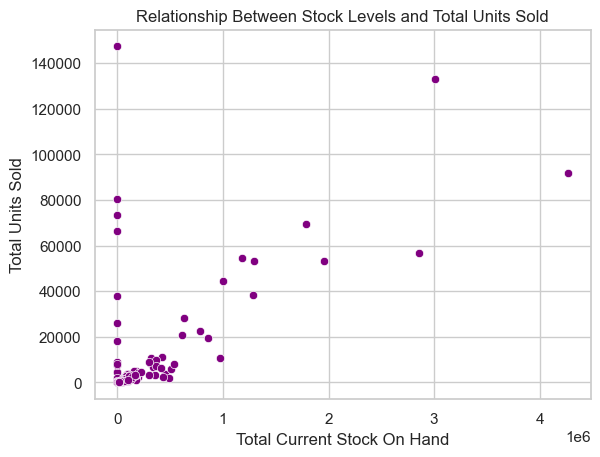

In [24]:

# Plot: Relationship Between Stock Levels and Total Units Sold

sns.scatterplot(data=saved_segment_group_data, x='TOTAL_CURRENT_ON_HAND', y='TOTAL_UNITS', color='purple')
plt.title('Relationship Between Stock Levels and Total Units Sold')
plt.xlabel('Total Current Stock On Hand')
plt.ylabel('Total Units Sold')


plt.show()

In [25]:
saved_segment_group_data.columns

Index(['SEGMENT', 'TOTAL_UNITS', 'LIST_PRICE', 'RATING_AVG', 'RATING_CNT',
       'TOTAL_CURRENT_ON_HAND'],
      dtype='object')

In [26]:
# Function to calculate outliers using IQR method
def find_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

# Calculating outliers for each metric
metrics = ['TOTAL_UNITS', 'LIST_PRICE', 'RATING_AVG', 'RATING_CNT', 'TOTAL_CURRENT_ON_HAND']
outliers_dict = {metric: find_outliers_iqr(saved_segment_group_data, metric) for metric in metrics}

outliers_dict.keys() # Displaying the keys to confirm successful calculation


dict_keys(['TOTAL_UNITS', 'LIST_PRICE', 'RATING_AVG', 'RATING_CNT', 'TOTAL_CURRENT_ON_HAND'])

In [27]:
outliers_dict

{'TOTAL_UNITS':                                                              SEGMENT  \
 ORDER_PLACED_DTTM                                                      
 2023-09-04                           Cat - Biscuits & Crunchy Treats   
 2023-09-04                                            Cat - Dry Food   
 2023-09-04                                     Cat - Lickable Treats   
 2023-09-04                                              Cat - Litter   
 2023-09-04                                 Cat - Soft & Chewy Treats   
 2023-09-04                                        Cat - Urinary Care   
 2023-09-04                                            Cat - Wet Food   
 2023-09-04                                   Cat - Wet Food Toppings   
 2023-09-04           Dog - Allergy, Sensitivities & Respiratory Care   
 2023-09-04                                  Dog - Balanced Nutrition   
 2023-09-04                                           Dog - Chew Toys   
 2023-09-04                         